Tiffany Kashima

Final Project DAT402

## Regularized Logistic Regression and Random Forest Classification 
## to Predict Banking Product Purchases

### Problem Statement

- Using the banking data set from the UCI Machine Learning Repository
- Gives attributes of customers who were given marketing phone calls to subscribe to a banking product
- Can we predict if a customer will subscribe to a banking product given the features of the data set?
- How does a Random Forest model compare to using LASSO logistic regression?

### Data Set
- Data contains over 11,000 observations
- Each observation is a unique customer record containing attributes such as age, education level, housing status, loan amounts, previous contact calls, days since previous contact, age, marital status, communication type, the type of marketing campaign, and success of previous marketing call
- Data is a mix of categorical and numerical data types
- Target variable is the yes or no binary outcome of the latest attempt to sell a banking product
- Source of data: https://archive.ics.uci.edu/ml/datasets/bank+marketing

### Desriptions of Column Data (https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets)

- age (numeric)
- job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services") 
- marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
- education (categorical: "unknown","secondary","primary","tertiary")
- default: has credit in default? (binary: "yes","no")
- balance: average yearly balance, in euros (numeric) 
- housing: has housing loan? (binary: "yes","no")
- loan: has personal loan? (binary: "yes","no")
- contact: contact communication type (categorical: "unknown","telephone","cellular") 
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
- previous: total number of contacts 
- performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
- y (target classifier) - has the client subscribed a term deposit? (binary: "yes","no")





### Logistic Regression with LASSO regularization

- Logistic Regression is an important, highly interpretable model that allows us to predict and binary outcome.

$P(Y=1|x) = F(x^T \beta), F(\eta)=\frac{e^\eta}{1+e^\eta}=\frac{1}{1+e^{-\eta}}$

where $x^T\beta$ is a linear combination the features in the model
and the logistic or sigmoid function, $F$, maps R to $(0,1)$

- A linear function, $\eta$, is fit to the data and it's values are used in the logistic function, $F$
- This is then used to formulate the probability of the binary outcomes
- In multiple regression, $\eta$ is a linear combination of features
- We evaluate the performance of the model by selecting for a the largest likelihood and smallest deviance

where deviance = $-2\sum_{i=1}^{n}log(P(Y=y_i|X=x_i,\beta))$


- LASSO or L1 Regularization improves on the idea of subset selection for features in a model by shrinking the coefficients in the model to zero.
- This essentially eliminates features that do not contribute significantly toward mapping the inputs to the outputs (modeling the signal or true relationship between x and y)
- LASSO uses the tuning parameter,$\lambda$ that penalizes for the number of coefficients by shrinking them to 0
- The advantage of LASSO is a computationally less expensive model that can achieve similar results with less features

In [437]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV


In [46]:
# random number intialization for notebook
rdm = 123

In [415]:
# read in data set
df = pd.read_csv("/Users/tk/ASU/DAT402/data/bank.csv", sep = ',', header=0)
df.dropna(inplace=True)

In [407]:
# preview data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [408]:
# data looks good - no null values , integer and object dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.5+ MB


In [409]:
# dimensions of data - 11162 observations, 15 features and 1 target
df.shape

(11162, 17)

In [410]:
# explore columns - can see that target is stored to 'y' column
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [411]:
# separate numeric and categorical variables and binary cateogrical variables
bincat = ['housing', 'default', 'loan']
num = ['age', 'balance', 'loan', 'pdays', 'previous', 'campaign']
cat = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

In [412]:
# summary stats on numeric variables
df[num].describe()

,age,balance,pdays,previous,campaign
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,51.330407,0.832557,2.508421
std,11.913369,3225.413326,108.758282,2.292007,2.722077
min,18.000000,-6847.000000,-1.000000,0.000000,1.000000
25%,32.000000,122.000000,-1.000000,0.000000,1.000000
50%,39.000000,550.000000,-1.000000,0.000000,2.000000
75%,49.000000,1708.000000,20.750000,1.000000,3.000000
max,95.000000,81204.000000,854.000000,58.000000,63.000000


In [54]:
# look at quantiles
df[num].quantile(np.arange(0.0, 1.1, 0.1))


,age,balance,pdays,previous,campaign
0.0,18.0,-6847.0,-1.0,0.0,1.0
0.1,28.0,0.0,-1.0,0.0,1.0
0.2,31.0,62.0,-1.0,0.0,1.0
0.3,33.0,189.3,-1.0,0.0,1.0
0.4,36.0,337.0,-1.0,0.0,1.0
0.5,39.0,550.0,-1.0,0.0,2.0
0.6,42.0,862.6,-1.0,0.0,2.0
0.7,47.0,1340.7,-1.0,0.0,2.0
0.8,52.0,2223.0,95.0,1.0,3.0
0.9,58.0,3897.6,191.0,3.0,5.0


In [55]:
# class balance for our target variable, having a balanced target classification set is important to our learners
df['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

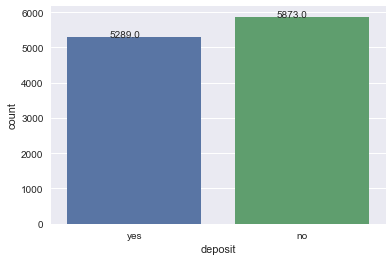

In [56]:
# visualizing responses from target variable
ax = sns.countplot(x = 'deposit', data= df)

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

In [57]:
print(f"Conversion Percentage is: {len(df.loc[df['deposit']=='yes'])/len(df)*100}" )
print(f"Non-conversion Percentage is: {len(df.loc[df['deposit']=='no'])/len(df)*100}")

Conversion Percentage is: 47.38398136534671
Non-conversion Percentage is: 52.61601863465329


In [336]:
# remove highly correlated variable "duration".  This variable is essentially the same as the yes or no target variable.
df.drop('duration', axis=1, inplace=True)

In [337]:
# drop days, we will just use month
df.drop('day', axis=1, inplace=True)

In [338]:
# convert pdays = -1 to a value that reflects essentially outside of relevant time.  -1 refers to no previous contact
df.pdays.replace(-1, 999, inplace=True)
df

,deposit,age,job,marital,education,default,balance,housing,loan,contact,month,campaign,pdays,previous,poutcome
0,1,59,admin.,married,secondary,no,2343,yes,no,unknown,may,1,999,0,unknown
1,1,56,admin.,married,secondary,no,45,no,no,unknown,may,1,999,0,unknown
2,1,41,technician,married,secondary,no,1270,yes,no,unknown,may,1,999,0,unknown
3,1,55,services,married,secondary,no,2476,yes,no,unknown,may,1,999,0,unknown
4,1,54,admin.,married,tertiary,no,184,no,no,unknown,may,2,999,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0,33,blue-collar,single,primary,no,1,yes,no,cellular,apr,1,999,0,unknown
11158,0,39,services,married,secondary,no,733,no,no,unknown,jun,4,999,0,unknown
11159,0,32,technician,single,secondary,no,29,no,no,cellular,aug,2,999,0,unknown
11160,0,43,technician,married,secondary,no,0,no,yes,cellular,may,2,172,5,failure


In [61]:
# avg value for response for select features
df.groupby('deposit').mean()

,age,balance,campaign,pdays,previous
deposit,,,,,
no,40.837391,1280.227141,2.839264,35.685340,0.528350
yes,41.670070,1804.267915,2.141047,68.702968,1.170354


In [62]:
# looking at averages for our numerical features by categories of the categorical variables, note there are some 'unknown' categories acorss the columns
for i in cat:
    print(df.groupby(i).mean())

                     age      balance  campaign      pdays  previous
job                                                                 
admin.         39.374063  1195.866567  2.376312  64.338831  0.973763
blue-collar    39.505144  1203.926440  2.541152  44.061214  0.633230
entrepreneur   42.887195  1621.942073  2.725610  32.746951  0.536585
housemaid      47.445255  1366.160584  2.689781  33.540146  0.503650
management     40.218239  1793.663679  2.588075  54.456352  0.925175
retired        65.424165  2417.250643  2.131105  53.003856  0.994859
self-employed  39.809877  1865.372840  2.533333  45.039506  0.804938
services       38.141928  1081.171181  2.576381  51.546046  0.684724
student        26.102778  1500.783333  2.169444  68.683333  1.297222
technician     39.001646  1556.294569  2.642348  47.247394  0.843116
unemployed     40.997199  1314.719888  2.134454  55.985994  0.812325
unknown        46.857143  1945.457143  2.785714  55.728571  0.700000
                age      balance  

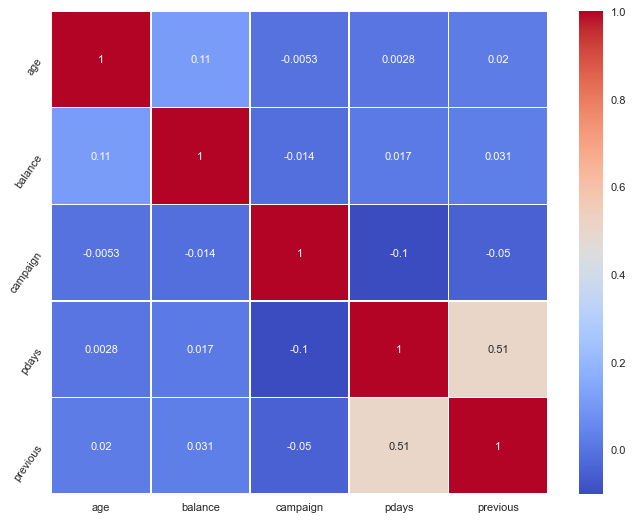

In [63]:
# the highest covariance is between the pair previous and pdays
plt.figure(figsize=(10,8),dpi=80)
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,linewidth=0.5)
plt.yticks(rotation=55)
plt.show()

Text(0, 0.5, 'Frequency of Purchase')

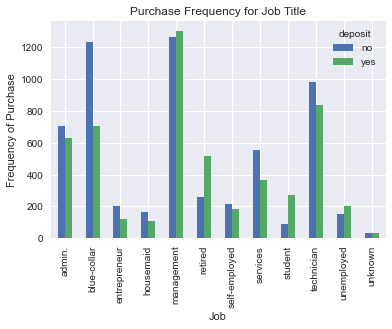

In [67]:
# There seems to be enough variation here that this could be a good model feature
pd.crosstab(df.job,df.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

Text(0, 0.5, 'Frequency of Purchase')

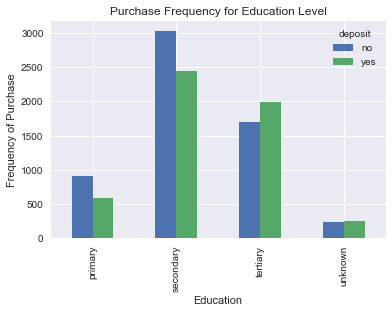

In [68]:
# most of the customers called had seconday and tertiary level of education.  THose with tertiary level had the highest conversion ratio.  
pd.crosstab(df.education,df.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Education Level')
plt.xlabel('Education')
plt.ylabel('Frequency of Purchase')

Text(0, 0.5, 'Frequency of Purchase')

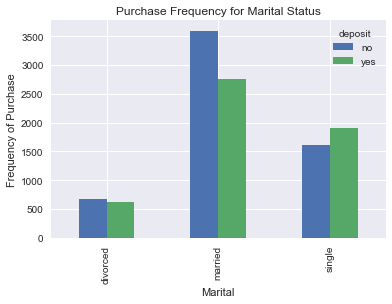

In [69]:
# conversions were higher for single status
pd.crosstab(df.marital,df.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Marital Status')
plt.xlabel('Marital')
plt.ylabel('Frequency of Purchase')

Text(0, 0.5, 'Frequency of Purchase')

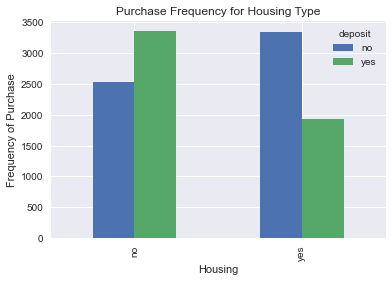

In [70]:
# conversions here much higher in this partcular category for those who do not own their own home
pd.crosstab(df.housing,df.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Housing Type')
plt.xlabel('Housing')
plt.ylabel('Frequency of Purchase')

Text(0, 0.5, 'Frequency of Purchase')

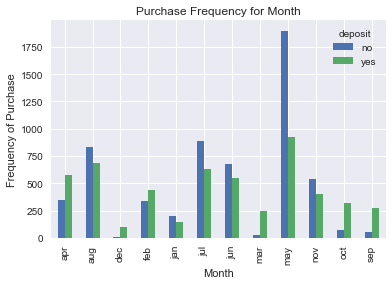

In [71]:
# overall more responses in may and higher proportion of yes to no responses in october, september, and december
pd.crosstab(df.month,df.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')

Text(0, 0.5, 'Frequency of Purchase')

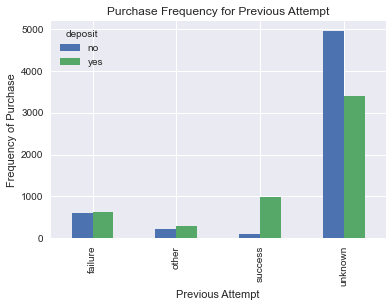

In [72]:
# probably not a great feature since most of the responses are unknown
pd.crosstab(df.poutcome,df.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Previous Attempt')
plt.xlabel('Previous Attempt')
plt.ylabel('Frequency of Purchase')

<AxesSubplot:xlabel='age', ylabel='Count'>

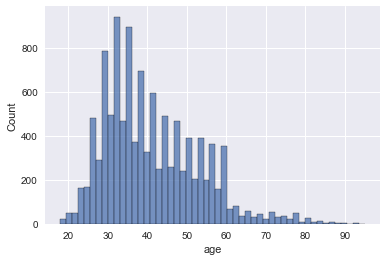

In [73]:
# the customers are mostly 30-50 years old
sns.histplot(x='age', data=df)

In [339]:
# Do some data pre-processing for logistic model

# one hot encode the categorical variables using pandas
dfenc = pd.get_dummies(df, columns=cat, prefix=cat)

In [340]:
dfenc.head()

,deposit,age,default,balance,housing,loan,campaign,pdays,previous,job_admin.,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1,59,no,2343,yes,no,1,999,0,1,...,0,0,1,0,0,0,0,0,0,1
1,1,56,no,45,no,no,1,999,0,1,...,0,0,1,0,0,0,0,0,0,1
2,1,41,no,1270,yes,no,1,999,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,55,no,2476,yes,no,1,999,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,54,no,184,no,no,2,999,0,1,...,0,0,1,0,0,0,0,0,0,1


In [341]:
# now we have 49 feature variables
dfenc.shape

(11162, 47)

In [342]:
%%capture
dfenc[bincat] = dfenc[bincat].replace({'yes':1, 'no':0})

In [343]:
# moving target variable to front of data set
x = dfenc.pop('deposit')
dfenc.insert(0, 'deposit', x)

In [344]:
# encode target variable into numeric binary response
dfenc['deposit'].replace({'no':0, 'yes':1}, inplace=True)
dfenc['deposit']

0        1
1        1
2        1
3        1
4        1
        ..
11157    0
11158    0
11159    0
11160    0
11161    0
Name: deposit, Length: 11162, dtype: int64

In [345]:
# store columns just in case we need to refer to them or relabel data set
columns = dfenc.iloc[:,1:].columns

In [346]:
columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [358]:
# create target and feature arrays
y = dfenc[['deposit']]
X = dfenc.iloc[:,1:]

In [359]:
X

,age,default,balance,housing,loan,campaign,pdays,previous,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,2343,1,0,1,999,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,56,0,45,0,0,1,999,0,1,0,...,0,0,1,0,0,0,0,0,0,1
2,41,0,1270,1,0,1,999,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,55,0,2476,1,0,1,999,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,54,0,184,0,0,2,999,0,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,1,1,0,1,999,0,0,1,...,0,0,0,0,0,0,0,0,0,1
11158,39,0,733,0,0,4,999,0,0,0,...,1,0,0,0,0,0,0,0,0,1
11159,32,0,29,0,0,2,999,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11160,43,0,0,0,1,2,172,5,0,0,...,0,0,1,0,0,0,1,0,0,0


In [360]:
# make train, test splits
trainX, testX, trainy, testy = train_test_split(X, y, test_size=.2, random_state=rdm, shuffle=True)

In [361]:
# Standardize the numeric features so that no one feature is "favored" due to bias in magnitude alone.  Only fit scaler to train data

ss = StandardScaler()
ss.fit(trainX[num])

StandardScaler()

In [362]:
# tranform testX and trainX
trainX[num]=ss.transform(trainX[num])
testX[num]=ss.transform(testX[num])

<ipython-input-362-33fa868055b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainX[num]=ss.transform(trainX[num])
/Users/tk/opt/miniconda3/envs/data-science-env/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-362-33fa868055b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [363]:
# convert to arrays for scikit learn
train_X = trainX.to_numpy()
train_y = trainy.to_numpy()

In [364]:
test_X = testX.to_numpy()
test_y = testy.to_numpy()

In [365]:
# Lets try logistic regression with L1/LASSO regularization and gridsearchCV for the tuning parameter in scikit-learn

param_grid = {'C':np.linspace(1, 50, 50)}
lfit = LogisticRegression(penalty='l1', solver='liblinear')
clf = GridSearchCV(lfit, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best = clf.fit(train_X, train_y.ravel())

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [366]:
best.best_score_

0.7026556378430432

In [367]:
best.best_index_

6

In [368]:
best.best_params_

{'C': 7.0}

In [369]:
best.best_estimator_

LogisticRegression(C=7.0, penalty='l1', solver='liblinear')

In [370]:
logreg = LogisticRegression(penalty='l1', solver='liblinear', C=7.0)
logreg.fit(train_X, train_y.ravel())

LogisticRegression(C=7.0, penalty='l1', solver='liblinear')

In [371]:
ypreds = logreg.predict(train_X)

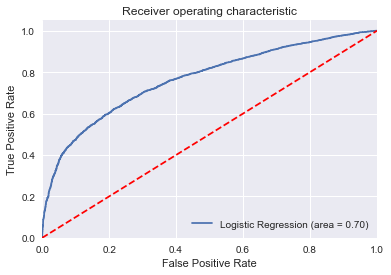

In [372]:
logit_roc_auc = roc_auc_score(train_y, ypreds)
fpr, tpr, thresholds = roc_curve(train_y, logreg.predict_proba(train_X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [373]:
print(classification_report(train_y, ypreds))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      4727
           1       0.74      0.58      0.65      4202

    accuracy                           0.71      8929
   macro avg       0.71      0.70      0.70      8929
weighted avg       0.71      0.71      0.70      8929



In [374]:
# Now lets try this with l2 regularization

param_grid = {'C':np.linspace(1,100,100)}
lfit2 = LogisticRegression(penalty='l2', solver='liblinear')
clf2 = GridSearchCV(lfit2, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best2 = clf2.fit(train_X, train_y.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [375]:
best2.best_params_

{'C': 1.0}

In [376]:
best2.best_score_

0.702431861882491

In [378]:
logreg2 = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')

In [379]:
# looks great, so lets do the test data with l2 and C=50 paramter

logreg2 = logreg2.fit(train_X, train_y.ravel())
ypreds2 = logreg2.predict(train_X)

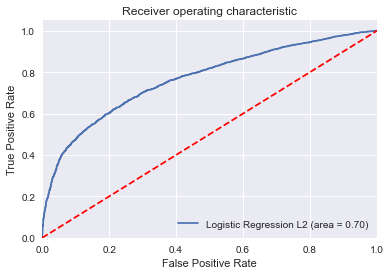

In [380]:
logit_roc_auc = roc_auc_score(train_y, ypreds2)
fpr, tpr, thresholds = roc_curve(train_y, logreg2.predict_proba(train_X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression L2 (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [381]:
print(classification_report(train_y, ypreds2))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      4727
           1       0.74      0.58      0.65      4202

    accuracy                           0.71      8929
   macro avg       0.71      0.70      0.70      8929
weighted avg       0.71      0.71      0.70      8929



In [382]:
# Compare test performace from both L1 and L2

In [383]:
yhats = logreg.predict(test_X)
yhats2 = logreg2.predict(test_X)

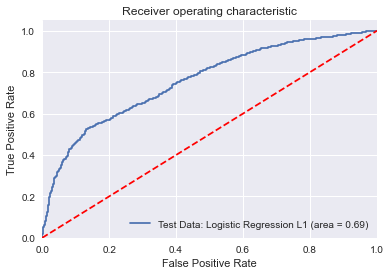

In [384]:
logit_roc_auc = roc_auc_score(testy, yhats)
fpr, tpr, thresholds = roc_curve(testy, logreg.predict_proba(test_X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Test Data: Logistic Regression L1 (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [385]:
print(classification_report(testy, yhats))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73      1146
           1       0.74      0.56      0.64      1087

    accuracy                           0.69      2233
   macro avg       0.70      0.69      0.68      2233
weighted avg       0.70      0.69      0.68      2233



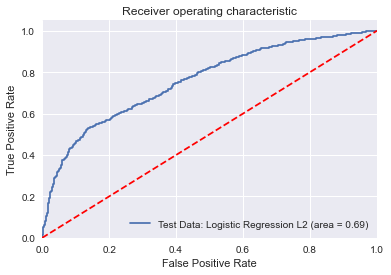

In [386]:
logit_roc_auc = roc_auc_score(testy, yhats2)
fpr, tpr, thresholds = roc_curve(testy, logreg2.predict_proba(test_X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Test Data: Logistic Regression L2 (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [387]:
print(classification_report(testy, yhats2))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73      1146
           1       0.74      0.57      0.64      1087

    accuracy                           0.69      2233
   macro avg       0.70      0.69      0.69      2233
weighted avg       0.70      0.69      0.69      2233



In [388]:
# Performance is bad with L1 and L2 regularized regression, even with some hyperparameter tuning.

# try random forest classification learner

### Random Forests


In [300]:
import scipy
import math
from numpy import mean
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [389]:
# scaled data not necessary for random forest
testX[num] = ss.inverse_transform(testX[num])

<ipython-input-389-3fe8ce930de6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testX[num] = ss.inverse_transform(testX[num])
/Users/tk/opt/miniconda3/envs/data-science-env/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [390]:
trainX[num] = ss.inverse_transform(trainX[num])

<ipython-input-390-dca0b2284517>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainX[num] = ss.inverse_transform(trainX[num])


In [391]:
train_X = trainX.to_numpy()
test_X = testX.to_numpy()
train_y = trainy.to_numpy()
test_y = testy.to_numpy()

In [393]:
# Tune a random Forest

# Num of trees in random forest
n_estimators = list(np.arange(10, 2000, 10))
# Max number of levels in tree
max_depth = list(np.arange(10, 100, 1))
max_depth.append(None)

random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}

In [423]:
# search for ideal parameters
rf = RandomForestClassifier(random_state=rdm)
cv = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=rdm, n_jobs = -1)

cv.fit(train_X,train_y.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, 31, 32, 33,
                                                      34, 35, 36, 37, 38, 39, ...],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                 

In [424]:
cv.best_score_

0.729197587209576

In [425]:
cv.best_params_

{'n_estimators': 1360, 'max_depth': 16}

In [426]:
print(f'THe best parameters are: {cv.best_params_}')

THe best parameters are: {'n_estimators': 1360, 'max_depth': 16}


In [427]:
# create model with best tuning paramters
bestmodel = RandomForestClassifier(n_estimators= 620, max_depth= 15, random_state=rdm)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rdm)

scorestr = cross_val_score(bestmodel, train_X, train_y, scoring='roc_auc', cv=cv, n_jobs=-1)

# Looks good so we will fit this model
print('Mean ROC AUC: %.3f' % mean(scorestr))

bestmodel.fit(trainX, trainy)

# make predictions on train data
predict = bestmodel.predict(trainX)


Mean ROC AUC: 0.782


<ipython-input-427-8001680220ed>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bestmodel.fit(trainX, trainy)


In [428]:
# results for trian data
print(classification_report(predict,trainy))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      5514
           1       0.76      0.93      0.84      3415

    accuracy                           0.86      8929
   macro avg       0.86      0.88      0.86      8929
weighted avg       0.88      0.86      0.86      8929



In [431]:
importance = bestmodel.feature_importances_
std = np.std([tree.feature_importances_ for tree in bestmodel.estimators_], axis=0)

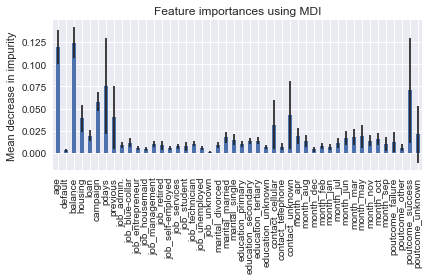

In [432]:
# feature importance shows us that 
forest_importance = pd.Series(importance, index=columns)

fig, ax = plt.subplots()
forest_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [434]:
# now on test data
scoreste = cross_val_score(bestmodel, testX, testy, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % mean(scoreste))

# make predictions on test data
yhat = bestmodel.predict(testX)


Mean ROC AUC: 0.760


In [435]:
# results for test data
print(classification_report(yhat,testy))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1376
           1       0.61      0.77      0.68       857

    accuracy                           0.72      2233
   macro avg       0.72      0.73      0.72      2233
weighted avg       0.74      0.72      0.72      2233



### Gradient Boosting

In [448]:
trainX = trainX.to_numpy()
trainy = trainy.to_numpy()
testX = testX.to_numpy()
testy = testy.to_numpy()

In [450]:
# Now lets model our predictions using Gradient Boosting

#tune a model using n_estimators and max-depth and learning rate with 5 fold cross validation

param = {'n_estimators':[50,100,200], 'max_depth':[4,6], 'learning_rate':[0.01, 0.5]}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(max_features='sqrt',subsample=0.8,random_state=rdm), param_grid = param, scoring='roc_auc',n_jobs=4, cv=5)
gsearch.fit(trainX,trainy.ravel())


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=123,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.5], 'max_depth': [4, 6],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [452]:
print(f"{gsearch.best_score_} ',' {gsearch.best_params_} ',' {gsearch.best_estimator_}")

0.7788014281707167 ',' {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200} ',' GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features='sqrt',
                           n_estimators=200, random_state=123, subsample=0.8)


In [453]:
# now build a model using the best tuning paramters

gb = GradientBoostingClassifier(n_estimators= 200, max_depth= 6, learning_rate= .01, random_state=rdm)
gb.fit(trainX, trainy)

/Users/tk/opt/miniconda3/envs/data-science-env/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingClassifier(learning_rate=0.01, max_depth=6, n_estimators=200,
                           random_state=123)

In [454]:
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rdm)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [455]:
evaluate_model(gb, trainX, trainy)

array([0.72228443, 0.73796193, 0.71668533, 0.71892497, 0.72676372,
       0.72340426, 0.69540873, 0.73460246, 0.73460246, 0.72309417,
       0.72900336, 0.70660694, 0.70884658, 0.72900336, 0.74132139,
       0.71780515, 0.74020157, 0.72004479, 0.73348264, 0.69618834,
       0.70660694, 0.72116461, 0.71220605, 0.71332587, 0.72340426,
       0.75363942, 0.71780515, 0.74132139, 0.72676372, 0.71300448])

In [456]:
sub_tree_rdm = gb.estimators_[10,0]

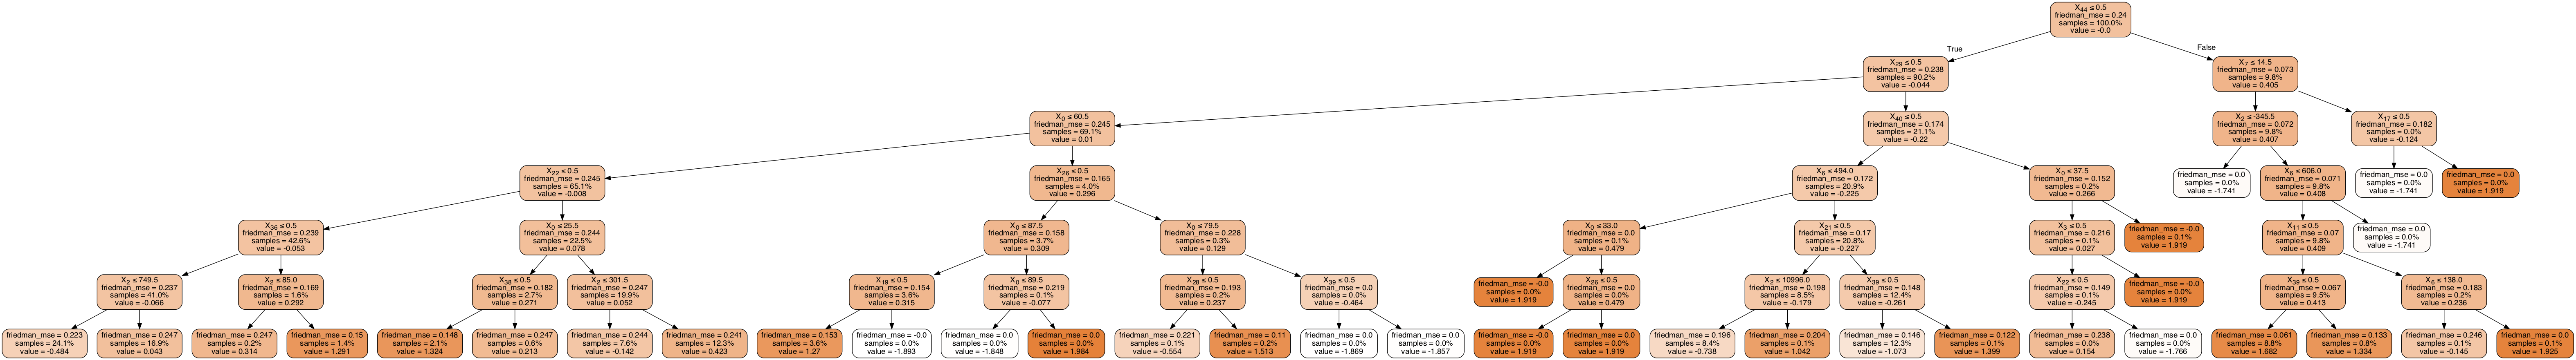

In [457]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_rdm,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=True, impurity=True
    )
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())

In [458]:
yhat = gb.predict(testX)
print(classification_report(testy, yhat))

              precision    recall  f1-score   support

           0       0.67      0.87      0.76      1146
           1       0.81      0.55      0.66      1087

    accuracy                           0.72      2233
   macro avg       0.74      0.71      0.71      2233
weighted avg       0.74      0.72      0.71      2233

